In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [2]:
from google.colab import drive
drive.mount('/content/my')

Drive already mounted at /content/my; to attempt to forcibly remount, call drive.mount("/content/my", force_remount=True).


data cleaning and exploration process

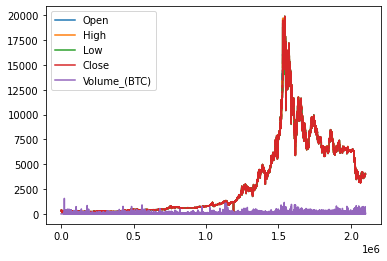

In [3]:
path = 'my/My Drive/'
data = pd.read_csv(path+'coinbaseUSD.csv')
data = data.dropna()#cleaning
data.head()
data[['Open','High','Low','Close','Volume_(BTC)']].plot()#overview of the data

#use a small portion of data as an example to avoid a crash of colab

In [21]:
data = data['Close'].iloc[int(0.5*len(data)):int(0.51*len(data))]
print(data.shape)

(19907,)


Function to do ADF test check for stationarity

In [10]:
def stationary_test(data):#ADF
    test_stats = adfuller(data)
    summary1 = pd.Series(test_stats[0:4],
                         index=['ADF statistic', 'P value', 'number of lags', 'number of observations'])
    critics = [test_stats[4][key] for key in test_stats[4]]
    summary2 = pd.Series(critics, index=['1% critic value', '5% critic value', '10% critic value'])
    summary = pd.concat([summary1, summary2], axis=0)
    print(summary)
     

In [22]:
stationary_test(data)

ADF statistic                -0.798805
P value                       0.819473
number of lags               41.000000
number of observations    19865.000000
1% critic value              -3.430679
5% critic value              -2.861686
10% critic value             -2.566847
dtype: float64


A high P-value indicates a failure to reject the H_0, thus this series is not stationary.

Built ARIMA model

In [23]:
class ARIMA_model():
    def __init__(self, train, test):#Series
        self.train = train
        self.test = test

    def plot_acf_pacf(self, data):
        fig, axes = plt.subplots(1,2)
        plot_acf(data, ax=axes[0])
        plot_pacf(data, ax=axes[1])

    def forecast(self, p,d,q):
        model_fit = ARIMA(self.train.values, (p,d,q)).fit(disp=-1)
        print(model_fit.summary())
        pred, se, conf = model_fit.forecast(len(test.index), alpha = 0.05)
        plt.figure()
        plt.plot(train.index, train)
        plt.plot(test.index, pred)
        plt.fill_between(test.index, conf[:,0], conf[:,1], alpha = 0.15)
        plt.plot(test.index, test)
        plt.legend(['train','prediction','test'])
        plt.show()
        return model_fit

        return model

In [24]:
#train, test split
train = data.iloc[:int(0.7*len(data))]
test = data.iloc[int(0.7*len(data)):]
print(len(train),len(test))
#ARIMA
model = ARIMA_model(train, test)
print(data.shape)

13934 5973
(19907,)


Determining DoF of the ARIMA by looking at the ACF and PACF

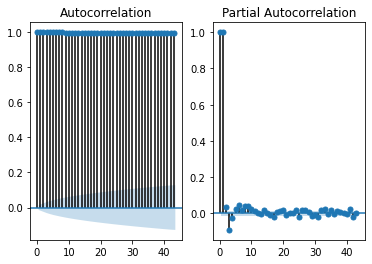

In [26]:
model.plot_acf_pacf(data)

This ACF shows a obvious nonstationarity. So at least 1 order difference should be done.

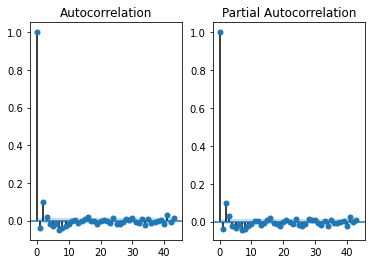

In [27]:
model.plot_acf_pacf(np.diff(data))

Now, these looks fine. From the acf, I guess q=3, while p=3 from the pacf. In this case, the ARIMA model would be of order (3,1,3)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                13933
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -13229.842
Method:                       css-mle   S.D. of innovations              0.625
Date:                Thu, 02 Jul 2020   AIC                          26475.684
Time:                        18:29:25   BIC                          26536.020
Sample:                             1   HQIC                         26495.775
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      1.868      0.062      -0.000       0.016
ar.L1.D.y     -0.5266      0.210     -2.512      0.012      -0.938      -0.116
ar.L2.D.y     -0.5733      0.134     -4.265      0.0

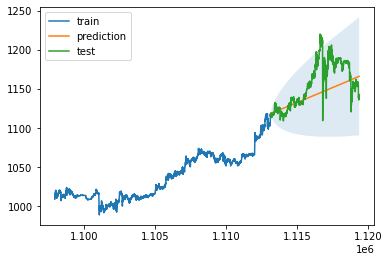

In [28]:
model_fit = model.forecast(3,1,3)

This prediction looks good since its predicts in a right direction and the predictions at the early stages are inside the confidence bond.

Try a simpler model?

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                13933
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13234.669
Method:                       css-mle   S.D. of innovations              0.626
Date:                Thu, 02 Jul 2020   AIC                          26481.338
Time:                        18:32:30   BIC                          26526.590
Sample:                             1   HQIC                         26496.406
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      1.846      0.065      -0.000       0.016
ar.L1.D.y      0.0967      0.138      0.700      0.484      -0.174       0.367
ar.L2.D.y     -0.1301      0.043     -3.032      0.0

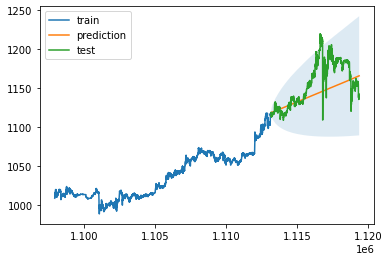

In [29]:
model_fit2 = model.forecast(2,1,2)

Since this one has a higher AIC, I will stick to the previous model.

Plot residue to see if needs variance analysis.

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 7.000e+00, 1.000e+01, 1.600e+01,
        1.400e+01, 3.500e+01, 3.300e+01, 6.000e+01, 5.800e+01, 8.500e+01,
        1.250e+02, 1.660e+02, 2.680e+02, 3.830e+02, 5.700e+02, 9.000e+02,
        6.092e+03, 2.278e+03, 1.072e+03, 6.730e+02, 3.850e+02, 2.530e+02,
        1.400e+02, 8.100e+01, 6.700e+01, 3.600e+01, 1.800e+01, 1.700e+01,
        1.000e+01, 8.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 4.000e+0

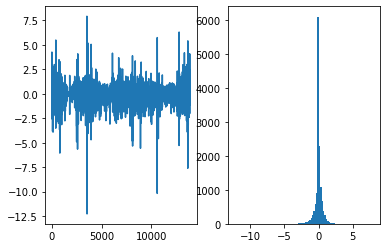

In [35]:
residue = model_fit.resid
plt.figure()
plt.subplot(1,2,1)
plt.plot(residue)
plt.subplot(1,2,2)
plt.hist(residue, bins=100)

Function to do Ljung box test to see if any further ARCh or GARCH is needed

In [30]:
def residue_variance_test(data, lag):#ljung box
    data_square = np.square(data)
    test_stats = acorr_ljungbox(data_square, lags=lag)
    d = {'LJung statistic':test_stats[0], 'P-values': test_stats[1]}
    summary = pd.DataFrame(d)
    print(summary)

In [31]:
residue_variance_test(model_fit.resid, 10)

   LJung statistic       P-values
0      1014.694640  1.148693e-222
1      1057.751617  2.051893e-230
2      1127.581885  3.776623e-244
3      1161.758689  3.105553e-250
4      1221.918677  5.250233e-262
5      1335.140302  2.674435e-285
6      1448.768135  1.081041e-308
7      1500.898626   0.000000e+00
8      1542.178955   0.000000e+00
9      1548.914587   0.000000e+00


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


So here shows strong correlation of residues, which indicates a necessary further ARCH modeling. 